In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from sqlalchemy import create_engine

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("seaborn-darkgrid")
plt.rcParams["figure.figsize"] = (16,9)
plt.rcParams["image.cmap"] = "Spectral"

In [4]:
eng = create_engine("sqlite:///lamost.db4")

In [5]:
data = pd.read_csv("catalog/dr4_v2_stellar.csv.gz",
                   sep="|", na_values=[-9999.00, "NULL"],
                   low_memory=False)

In [6]:
basename = data["lmjd"].map("spec-{:5d}-".format) \
         + data["planid"].map("{}".format)        \
         + data["spid"].map("_sp{:02d}-".format)  \
         + data["fiberid"].map("{:03d}".format)
         #+ ".fits"
data["basename"] = basename

In [9]:
tip = ["teff", "logg", "feh"]
top = ["teff_err", "logg_err", "feh_err"]
key = ",".join(tip+top)
sky = "ra,dec,feh"

In [10]:
lama = glob.glob("sample/*.fits")
with open("lamost.lst", "w") as lst:
    for fln in lama:
        lst.write(os.path.basename(fln.rstrip(".fits\n"))+"\n")
most = pd.DataFrame({"basename": open("lamost.lst").readlines()})
most.basename = most.basename.map(str.strip)
merg = most.merge(data)
merg.to_sql("sample", eng, if_exists="replace")
merg["teff"] = np.log10(merg["teff"])
np.save("lamost.npy", merg[tip].values)

In [ ]:
star = pd.read_sql(f"SELECT {key} FROM star", eng)
samp = pd.read_sql(f"SELECT {key} FROM sample", eng)
coor = pd.read_sql(f"SELECT {sky} FROM sample", eng)

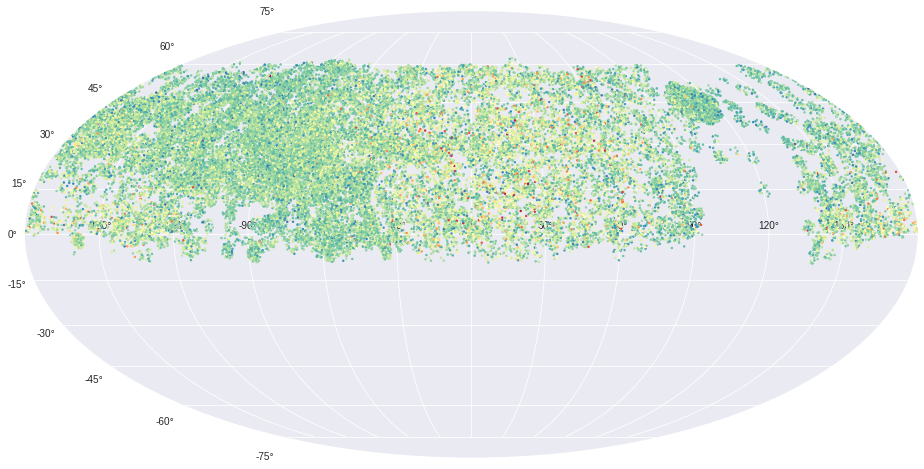

In [39]:
plt.subplot(projection="mollweide")
plt.scatter(np.radians(coor["ra"])-np.pi,
            np.radians(coor["dec"]),
            c=coor["feh"], s=2);

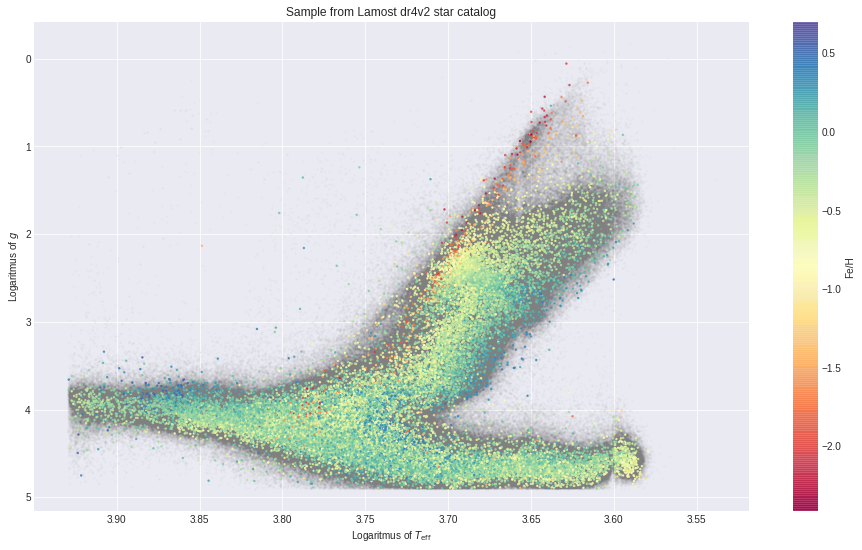

In [19]:
plt.title("Sample from Lamost dr4v2 star catalog")
plt.xlabel("Logaritmus of $T_\mathrm{eff}$")
plt.ylabel("Logaritmus of $g$")
plt.gca().invert_xaxis(); plt.gca().invert_yaxis();
plt.scatter(np.log10(star["teff"]), star["logg"],
            c="gray", s=2, alpha=0.02);
plt.scatter(np.log10(samp["teff"]), samp["logg"],
            c=samp["feh"], s=2, alpha=0.8);
plt.colorbar().ax.set_ylabel("Fe/H");

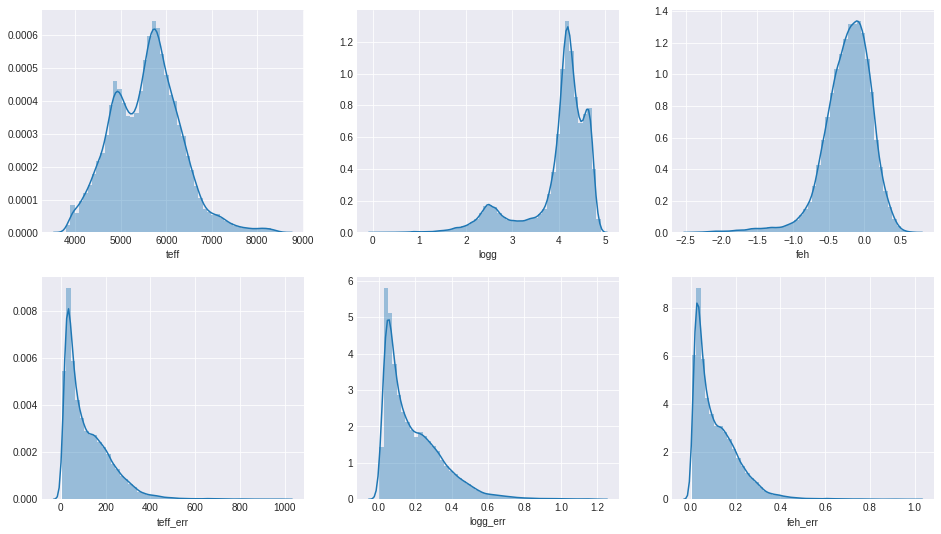

In [32]:
for i, val in enumerate(tip+top):
    plt.subplot(2, 3, 1+i)
    sns.distplot(samp[val].dropna())